# Práctica 6: Modelos lineales con scipy.stats

Esta práctica aborda el uso de la librería [**Scipy**](https://www.scipy.org/) para ajustar regresiones lineales a nuestros datos y poder pronosticar aquellas variables que estén correlacionadas.

Esta práctica **no hace distinción entre los niveles del factor función de activación** para las capas ocultas. Antes de ajustar una regresión lineal a nuestros datos es bueno averiguar si existen diferencias significativas entre los niveles de los factores restantes, es decir, partición, número de neuronas, número capas y alpha. Sin embargo, primero se debe conocer la distribución de los datos para saber que tipo de prueba aplicar para la diferencia significativa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, mannwhitneyu, wilcoxon,  kruskal
from scipy import stats
pd.set_option('max_rows', 10)

In [2]:
d = pd.read_csv("../lbfgs_crudo.csv")
d

,Unnamed: 0,partition,layer_num,neurona_num,activation,alpha,train_accuracy,training_time,test_accuracy
0,1728,10,1,30,logistic,0.0001,0.927833,23.156492,0.8789
1,1729,10,1,30,logistic,1.0000,0.950167,21.880265,0.8949
2,1730,10,1,30,logistic,10000.0000,0.802000,6.253907,0.8065
3,1731,10,1,30,tanh,0.0001,0.926333,22.267032,0.8854
4,1732,10,1,30,tanh,1.0000,0.910000,22.207077,0.8725
...,...,...,...,...,...,...,...,...,...
8625,29563,90,10,210,logistic,1.0000,0.100000,30.609275,0.0974
8626,29564,90,10,210,logistic,10000.0000,0.100000,152.781862,0.0958
8627,29565,90,10,210,tanh,0.0001,0.999741,608.635419,0.9586
8628,29566,90,10,210,tanh,1.0000,0.999667,667.529777,0.9548


In [27]:
part=dict()
for i in d.partition.unique():
    part[str(i)]=d.test_accuracy[d.partition==i]
    s,p = shapiro(part[str(i)])
    if p>0.05:
        print('la distribucion de los resultados utilizando el {} porciento de entrenamiento es normal'.format(i))
    else:
        print('la distribucion de los resultados utilizando el {} porciento de entrenamiento es no normal'.format(i))

la distribucion de los resultados utilizando el 10 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 20 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 30 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 40 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 50 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 60 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 70 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 80 porciento de entrenamiento es no normal
la distribucion de los resultados utilizando el 90 porciento de entrenamiento es no normal


In [42]:
capas=dict()
for i in d.layer_num.unique():
    capas[str(i)]=d.test_accuracy[d.layer_num==i]
    s,p = shapiro(capas[str(i)])
    if p>0.05:
        print('la distribucion de los resultados utilizando {} capas de entrenamiento es normal'.format(i))
    else:
        print('la distribucion de los resultados utilizando {} capas de entrenamiento es no normal'.format(i))

la distribucion de los resultados utilizando 1 capas de entrenamiento es no normal
la distribucion de los resultados utilizando 4 capas de entrenamiento es no normal
la distribucion de los resultados utilizando 7 capas de entrenamiento es no normal
la distribucion de los resultados utilizando 10 capas de entrenamiento es no normal


In [45]:
neuronas=dict()
for i in d.neurona_num.unique():
    neuronas[str(i)]=d.test_accuracy[d.neurona_num==i]
    s,p = shapiro(neuronas[str(i)])
    if p>0.05:
        print('la distribucion de los resultados utilizando {} neuronas por capa en el entrenamiento es normal'.format(i))
    else:
        print('la distribucion de los resultados utilizando {} neuronas por capa en el entrenamiento es no normal'.format(i))

la distribucion de los resultados utilizando 30 neuronas por capa en el entrenamiento es no normal
la distribucion de los resultados utilizando 90 neuronas por capa en el entrenamiento es no normal
la distribucion de los resultados utilizando 150 neuronas por capa en el entrenamiento es no normal
la distribucion de los resultados utilizando 210 neuronas por capa en el entrenamiento es no normal


In [46]:
alfas=dict()
for i in d.alpha.unique():
    alfas[str(i)]=d.test_accuracy[d.alpha==i]
    s,p = shapiro(alfas[str(i)])
    if p>0.05:
        print('la distribucion de los resultados utilizando alpha={} en el entrenamiento es normal'.format(i))
    else:
        print('la distribucion de los resultados utilizando alpha={} en el entrenamiento es no normal'.format(i))

la distribucion de los resultados utilizando alpha=0.0001 en el entrenamiento es no normal
la distribucion de los resultados utilizando alpha=1.0 en el entrenamiento es no normal
la distribucion de los resultados utilizando alpha=10000.0 en el entrenamiento es no normal


Al tomar en cuenta solo los niveles de un factor a la vez (tomando todos los niveles de los demás factores), se obtiene que **ningún conjunto de datos presenta una distribución normal**. Con esta observación la prueba a aplicar es la **kruskal** la cual infiere diferencias significativas entre conjuntos de datos que no tienen una distribución normal.

In [40]:
niv={'particiones': [g[1].test_accuracy for g in d.groupby(['partition'])],
    'numero_capas': [g[1].test_accuracy for g in d.groupby(['layer_num'])],
    'numero_neuronas': [g[1].test_accuracy for g in d.groupby(['neurona_num'])],
    'alpha': [g[1].test_accuracy for g in d.groupby(['alpha'])],
    'activacion': [g[1].test_accuracy for g in d.groupby(['activation'])]}

print('\n'.join([("insufientes datos" if min([len(x) for x in niv[d]]) < 5 else \
                  "sin diferencia" if kruskal(*niv[d])[1] > a else "hay diferencia") +  \
                 " para " +  d for d in niv]))

hay diferencia para particiones
hay diferencia para numero_capas
hay diferencia para numero_neuronas
hay diferencia para alpha
hay diferencia para activacion


Los resultados de la prueba kruskel, es que al menos un par de niveles en cada uno de ls factores presenta diferencia significativa. **Esto quiere decir que en cada factor existe al menos 2 niveles que tienen un efecto sobre la precisión de evaluación**. En lugar de hacer una prueba para cada par posible de niveles de cada factor, se calcula la correlación de cada factor con la precisión de evaluación y de esta forma “*estimar*” el efecto que tiene cada factor sobre la precisión de evaluación.

In [47]:
print('la correlacion entre la presision y el porcentaje de entrenamiento es de {}'.format(d.test_accuracy.corr(d.partition)))
print('la correlacion entre la presision y el las capas de entrenamiento es de {}'.format(d.test_accuracy.corr(d.layer_num)))
print('la correlacion entre la presision y el numero de neuronas de entrenamiento es de {}'.format(d.test_accuracy.corr(d.neurona_num)))
print('la correlacion entre la presision y el alpha de entrenamiento es de {}'.format(d.test_accuracy.corr(d.alpha)))

la correlacion entre la presision y el porcentaje de entrenamiento es de 0.014833048738554502
la correlacion entre la presision y el las capas de entrenamiento es de -0.4479539211276514
la correlacion entre la presision y el numero de neuronas de entrenamiento es de 0.01904899528556452
la correlacion entre la presision y el alpha de entrenamiento es de -0.3596427205097238


Como se observa en la parte superior el factor partición **afecta de manera positiva la precisión de evaluación, aunque la razón de cambio es despreciable**. En cambio, los factores de capas ocultas y alpha presentan una correlación mas fuerte, es decir la **precisión de evaluación es más susceptible a los cambios de estos parámetros**, aunque en este caso la razón de cambio es negativa, por lo tanto, a medida que aumentan estos parámetros la precisión disminuye. Por ultimo el numero de neuronas tiene una correlación baja al igual que el factor de partición. Es importante mencionar que estas observaciones concuerdan con las conclusiones de las practicas pasadas.

Para poder ver gráficamente como afecta cada uno de los niveles a la precisión de evaluación, se ajusta una regresión lineal entre el **número de capas y la precisión de evaluación**, y otra regresión entre **alpha y la precisión de evaluación**, se escogen estos dos factores porque son los que presentan una correlación mayor.

y = f(x) = -0.0555 x + 0.8216
error 0.0011931588976163855
valor p 0.0
pendiente significativo
R^2 0.20066271545363815


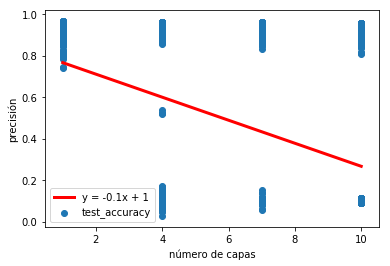

In [58]:
a,b,r,p,e=stats.linregress(d.layer_num, d.test_accuracy)
print("y = f(x) = {:.4f} x + {:.4f}".format(a, b))
print("error", e)
print("valor p", p)
print("pendiente {:s}significativo".format("no " if p >= 0.05 else ""))
print("R^2", r**2)

plt.plot(d.layer_num, (a * d.layer_num + b), label = 'y = {:.1f}x + {:.0f}'.format(a, b), color = 'red', linewidth = 3)
plt.scatter(d.layer_num, d.test_accuracy)
plt.legend(loc='lower left')
plt.xlabel("número de capas")
plt.ylabel("precisión")
plt.show()

y = f(x) = -0.0000 x + 0.6221
error 8.860244025138363e-07
valor p 7.557529557126648e-262
pendiente significativo
R^2 0.12934288641563535


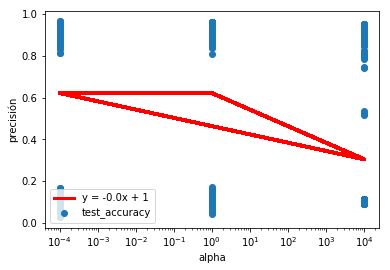

In [67]:
a,b,r,p,e=stats.linregress(d.alpha, d.test_accuracy)
print("y = f(x) = {:.4f} x + {:.4f}".format(a, b))
print("error", e)
print("valor p", p)
print("pendiente {:s}significativo".format("no " if p >= 0.05 else ""))
print("R^2", r**2)

plt.plot(d.alpha, (a * d.alpha + b), label = 'y = {:.1f}x + {:.0f}'.format(a, b), color = 'red', linewidth = 3)
plt.scatter(d.alpha, d.test_accuracy)
plt.legend(loc='lower left')
plt.xlabel("alpha")
plt.xscale('log')
plt.ylabel("precisión")
plt.show()

y = f(x) = 0.0001 x + 0.5022
error 6.67399401267327e-05
valor p 0.0768081640729033
pendiente no significativo
R^2 0.0003628642213894593


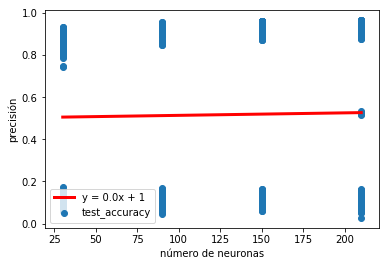

In [68]:
a,b,r,p,e=stats.linregress(d.neurona_num, d.test_accuracy)
print("y = f(x) = {:.4f} x + {:.4f}".format(a, b))
print("error", e)
print("valor p", p)
print("pendiente {:s}significativo".format("no " if p >= 0.05 else ""))
print("R^2", r**2)

plt.plot(d.neurona_num, (a * d.neurona_num + b), label = 'y = {:.1f}x + {:.0f}'.format(a, b), color = 'red', linewidth = 3)
plt.scatter(d.neurona_num, d.test_accuracy)
plt.legend(loc='lower left')
plt.xlabel("número de neuronas")
plt.ylabel("precisión")
plt.show()

Hay varios aspectos importantes que se pueden inferir de las regresiones anteriores, la primera es que todas las graficas presentan una especie de **agrupación en cada nivel del factor** y estas agrupaciones se forman en tres regiones de precisión de evaluación que bien podrían ser nombradas buena, regular y mala. El fenómeno anterior se debe a los niveles de los factores restantes, indicando que la combinación de factores juega un papel importante. Otra observación es que **los datos presentan un comportamiento no lineal, por lo que necesarios hacer regresiones con otro tipo de familias de funciones**. Por las practicas pasadas se sabe que los factores numero de capas y numero de neuronas son los factores que más afectan a la precisión de evaluación, por lo tanto, queda abierta la pregunta para la siguiente practica de ajuste de regresión múltiple.  